# Анализ итогов А/В теста

Задание:\
Представьте, что вы аналитик в компании которая разрабатывает 
приложение для обработки и оформления фотографий в формате Stories. Был 
проведен А/В тест: тестовой группе предлагалась новая модель оплаты 
коллекций шаблонов, контрольной – старая механика. Ваша основная задача: 
проанализировать итоги эксперимента и решить, нужно ли выкатывать новую 
модель на остальных пользователей.
В ходе отчета обоснуйте выбор метрик, на которые вы обращаете 
внимание. Если различия есть, то объясните, с чем они могут быть связаны и 
являются ли значимыми

In [93]:
#загрузка необходимых библиотек

In [381]:
import random
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
import pandas as pd
# загрузка библиотеки для работы со сылками
import requests
from urllib.parse import urlencode

In [382]:
# выгрузка данных с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/B4QnY5D5EtKa-A'  # ссылка

# Получение загрузочной ссылки
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
active_users=pd.read_csv(download_url)
active_users
# датасет active_users хранит в себе данные о пользователях, которые
# посещали приложение во время эксперимента

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [383]:
# выгрузка данных с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/jP_BAw_oxS3law'  # ссылка

# Получение загрузочной ссылки
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
groups=pd.read_csv(download_url)
groups
# датасет groups хранит в себе данные о принадлежности пользователей
# к контрольной либо тестовой группе

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B
...,...,...
74571,1010,B
74572,7785,A
74573,1783,B
74574,1164,A


In [384]:
# выгрузка данных с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/AmucCdboEaowhA'  # ссылка

# Получение загрузочной ссылки
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
purchases=pd.read_csv(download_url)
purchases
# датасет purchases хранит в себе данные о транзакциях
# пользователей приложения во время эксперимента

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [385]:
# знание о том, что пользователи были только из двух стран: из России и Швеции.
active_users.country.unique()

array(['Russia', 'Sweden'], dtype=object)

In [386]:
# получение датасета full_data с данными всех пользователей,
# учавствовавших в эксперименте, и их тратах на покупки в приложении
full_data=active_users.merge(purchases, on='user_id', how='left')
full_data['revenue']=full_data.revenue.fillna(0)
full_data

,user_id,country,platform,sex,revenue
0,8029,Russia,ios,male,0.0
1,1735,Sweden,ios,male,0.0
2,7697,Russia,android,male,0.0
3,1421,Sweden,android,female,0.0
4,1704,Russia,ios,male,0.0
...,...,...,...,...,...
8336,2417,Sweden,ios,female,0.0
8337,3755,Russia,ios,male,590.0
8338,4594,Sweden,android,female,0.0
8339,7430,Sweden,ios,female,0.0


# Проверка репрезентативности выборок для А/В теста

In [334]:
#объединение двух датасетов
groups_with_ditails=groups.merge(active_users, on='user_id')
groups_with_ditails

,user_id,group,country,platform,sex
0,1488,B,Russia,android,male
1,5125,B,Russia,ios,female
2,3196,A,Russia,ios,female
3,1749,B,Russia,android,male
4,4994,B,Sweden,android,male
...,...,...,...,...,...
8336,1010,B,Sweden,android,male
8337,7785,A,Sweden,android,male
8338,1783,B,Russia,ios,female
8339,1164,A,Sweden,android,male


In [102]:
#датасет с информацией о пользователях группы А (контрольной группы)
groups_with_ditails_A_control=groups_with_ditails.query('group=="A"')
groups_with_ditails_A_control.head(3)

,user_id,group,country,platform,sex
2,3196,A,Russia,ios,female
5,3800,A,Sweden,ios,male
6,5133,A,Russia,ios,female


In [103]:
#датасет с информацией о пользователях группы В (тестовой группы)
groups_with_ditails_B_test=groups_with_ditails.query('group=="B"')
groups_with_ditails_B_test.head(3)

,user_id,group,country,platform,sex
0,1488,B,Russia,android,male
1,5125,B,Russia,ios,female
3,1749,B,Russia,android,male


In [104]:
#количество пользователей из каждой из стран в группе А
groups_with_ditails_A_control.groupby('country')\
                             .agg({'user_id':'count'})

,user_id
country,
Russia,915
Sweden,623


In [105]:
#количество пользователей из каждой из стран в группе В
groups_with_ditails_B_test.groupby('country')\
                          .agg({'user_id':'count'})

,user_id
country,
Russia,4492
Sweden,2311


In [106]:
#количество пользователей каждой из платформ в группе А
groups_with_ditails_A_control.groupby('platform')\
                             .agg({'user_id':'count'})

,user_id
platform,
android,834
ios,704


In [107]:
#количество пользователей каждой из платформ в группе В
groups_with_ditails_B_test.groupby('platform')\
                          .agg({'user_id':'count'})

,user_id
platform,
android,3787
ios,3016


In [108]:
#количество пользователей разных полов в группе A
groups_with_ditails_A_control.groupby('sex')\
                             .agg({'user_id':'count'})

,user_id
sex,
female,753
male,785


In [109]:
#количество пользователей разных полов в группе В
groups_with_ditails_B_test.groupby('sex')\
                          .agg({'user_id':'count'})

,user_id
sex,
female,3392
male,3411


#  Проверка наличия статистически значимых различий в конверсиях в покупку 

In [110]:
# проверка, что все пользователи из датасета purchases реально 
#совершили покупки
purchases_with_flag=purchases
purchases_with_flag['Buying']=purchases_with_flag.revenue.apply(lambda x: x>0)
purchases_with_flag.head(3)

,user_id,revenue,Buying
0,4412,1000.0,True
1,9000,701.0,True
2,9001,700.0,True


In [111]:
purchases_with_flag.Buying.nunique()
#в датасете purchases нет пользователей с покупкой равной 0
# значит каждый совершил покупку

1

In [112]:
#Рассчет количества пользователей каждой из групп
count_A_B_users=groups.groupby('group')\
                      .agg({'user_id':'count'})
count_A_B_users

,user_id
group,
A,14693
B,59883


In [113]:
#формирование датасета покупателей, где видно к какой группе каждый относится
purchases_with_flag_with_A_B=purchases_with_flag.merge(groups,\
                                                       on='user_id')
purchases_with_flag_with_A_B.head(3)

,user_id,revenue,Buying,group
0,4412,1000.0,True,A
1,9000,701.0,True,B
2,9001,700.0,True,B


In [114]:
#Рассчет количества покупателей каждой из групп
bought=purchases_with_flag_with_A_B.groupby('group')\
                                   .agg({'user_id':'count'})
bought

,user_id
group,
A,107
B,434


In [115]:
#Рассчет конверсии в покупку каждой из групп
conventional_rate=bought/count_A_B_users
conventional_rate

,user_id
group,
A,0.007282
B,0.007247


In [116]:
#Проведение статистической оценки по критерию  Хи-квадрат.

from  scipy.stats import chi2_contingency
kf_data = np.array([[434,59883-434], [107,14693-107]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)



chisq-statistic=0.0000, p-value=1.0000, df=1 expected_frep=[[  434.41191536 59448.58808464]
 [  106.58808464 14586.41191536]]


In [117]:
# отбор пользователей только из России
A_B_rassia=groups_with_ditails.query('country=="Russia"')
A_B_rassia.head(3)

,user_id,group,country,platform,sex
0,1488,B,Russia,android,male
1,5125,B,Russia,ios,female
2,3196,A,Russia,ios,female


In [118]:
# подсчет количества пользователей из России для каждой из групп
count_A_B_users_rassia=A_B_rassia.groupby('group')\
                                 .agg({'user_id':'count'})
count_A_B_users_rassia

,user_id
group,
A,915
B,4492


In [119]:
purchases_with_flag_with_A_B.head(3)

,user_id,revenue,Buying,group
0,4412,1000.0,True,A
1,9000,701.0,True,B
2,9001,700.0,True,B


In [120]:
# формирование датасета о покупках и группах с пользователями только из России 
purchases_A_B_rassia=A_B_rassia.merge(purchases_with_flag_with_A_B, \
                                      on='user_id')
purchases_A_B_rassia.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,4455,B,Russia,android,female,599.0,True,B
1,5505,B,Russia,android,male,299.0,True,B
2,6163,B,Russia,ios,male,302.0,True,B


In [121]:
#расчет количества покупателей для каждой из групп пользователей России
count_purchases_A_B_rassia=purchases_A_B_rassia.groupby('group_x')\
                                               .agg({'user_id':'count'})
count_purchases_A_B_rassia

,user_id
group_x,
A,43
B,197


In [122]:
#Проведение статистической оценки по критерию  Хи-квадрат.
from  scipy.stats import chi2_contingency
import numpy as np
kf_data = np.array([[197,4295], [43,872]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=0.1103, p-value=0.7398, df=1 expected_frep=[[ 199.38598114 4292.61401886]
 [  40.61401886  874.38598114]]


In [123]:
# отбор пользователей только из Швеции
A_B_sweden=groups_with_ditails.query('country=="Sweden"')
A_B_sweden.head(3)

,user_id,group,country,platform,sex
4,4994,B,Sweden,android,male
5,3800,A,Sweden,ios,male
7,6918,B,Sweden,ios,female


In [124]:
# подсчет количества пользователей из Швеции для каждой из групп
count_A_B_users_sweden=A_B_sweden.groupby('group')\
                                 .agg({'user_id':'count'})
count_A_B_users_sweden

,user_id
group,
A,623
B,2311


In [125]:
# формирование датасета о покупках и группах с пользователями только из Швеции 
purchases_A_B_sweden=A_B_sweden.merge(purchases_with_flag_with_A_B,\
                                      on='user_id')
purchases_A_B_sweden.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,6473,B,Sweden,ios,female,3050.0,True,B
1,2814,B,Sweden,android,female,300.0,True,B
2,1673,A,Sweden,android,male,2899.0,True,A


In [126]:
#расчет количества покупателей для каждой из групп пользователей Швеции
count_purchases_A_B_sweden=purchases_A_B_sweden.groupby('group_x')\
                                               .agg({'user_id':'count'})
count_purchases_A_B_sweden

,user_id
group_x,
A,35
B,117


In [127]:
#Проведение статистической оценки по критерию  Хи-квадрат.
from  scipy.stats import chi2_contingency
import numpy as np
kf_data = np.array([[117,2194], [35,588]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=0.2053, p-value=0.6505, df=1 expected_frep=[[ 119.72460804 2191.27539196]
 [  32.27539196  590.72460804]]


In [128]:
# отбор пользователей только Android
A_B_android=groups_with_ditails.query('platform=="android"')
A_B_android.head(3)

,user_id,group,country,platform,sex
0,1488,B,Russia,android,male
3,1749,B,Russia,android,male
4,4994,B,Sweden,android,male


In [129]:
# подсчет количества пользователей Android для каждой из групп
count_A_B_users_A_B_android=A_B_android.groupby('group')\
                                       .agg({'user_id':'count'})
count_A_B_users_A_B_android

,user_id
group,
A,834
B,3787


In [130]:
# формирование датасета о покупках и группах с пользователями только c Android
purchases_A_B_android=A_B_android.merge(purchases_with_flag_with_A_B, \
                                        on='user_id')
purchases_A_B_android.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,4455,B,Russia,android,female,599.0,True,B
1,2814,B,Sweden,android,female,300.0,True,B
2,1673,A,Sweden,android,male,2899.0,True,A


In [131]:
purchases_A_B_android.nunique()

user_id     208
group_x       2
country       2
platform      1
sex           2
revenue      62
Buying        1
group_y       2
dtype: int64

In [132]:
#расчет количества покупателей для каждой из групп пользователей Android
count_purchases_A_B_android=purchases_A_B_android.groupby('group_x')\
                                                 .agg({'user_id':'count'})
count_purchases_A_B_android

,user_id
group_x,
A,39
B,169


In [133]:
#Проведение статистической оценки по критерию  Хи-квадрат 
from  scipy.stats import chi2_contingency
import numpy as np
kf_data = np.array([[169,3787-169], [39,834-39]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=0.0314, p-value=0.8594, df=1 expected_frep=[[ 170.46007358 3616.53992642]
 [  37.53992642  796.46007358]]


In [134]:
# отбор пользователей только IoS
A_B_ios=groups_with_ditails.query('platform=="ios"')
A_B_ios.head(3)

,user_id,group,country,platform,sex
1,5125,B,Russia,ios,female
2,3196,A,Russia,ios,female
5,3800,A,Sweden,ios,male


In [135]:
# подсчет количества пользователей IoS для каждой из групп
count_A_B_users_A_B_ios=A_B_ios.groupby('group')\
                               .agg({'user_id':'count'})
count_A_B_users_A_B_ios

,user_id
group,
A,704
B,3016


In [136]:
# формирование датасета о покупках и группах с пользователями только c IoS
purchases_A_B_ios=A_B_ios.merge(purchases_with_flag_with_A_B,\
                                on='user_id')
purchases_A_B_ios.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,6473,B,Sweden,ios,female,3050.0,True,B
1,7873,B,Sweden,ios,male,890.0,True,B
2,6163,B,Russia,ios,male,302.0,True,B


In [137]:
#расчет количества покупателей для каждой из групп пользователей IoS
count_purchases_A_B_ios=purchases_A_B_ios.groupby('group_x')\
                                         .agg({'user_id':'count'})
count_purchases_A_B_ios

,user_id
group_x,
A,39
B,145


In [138]:
#Проведение статистической оценки по критерию  Хи-квадрат 
from  scipy.stats import chi2_contingency
import numpy as np
kf_data = np.array([[145,3016-145], [39,704-39]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=0.5042, p-value=0.4776, df=1 expected_frep=[[ 149.17849462 2866.82150538]
 [  34.82150538  669.17849462]]


In [139]:
# отбор пользователей только мужского пола
A_B_male=groups_with_ditails.query('sex=="male"')
A_B_male.head(3)

,user_id,group,country,platform,sex
0,1488,B,Russia,android,male
3,1749,B,Russia,android,male
4,4994,B,Sweden,android,male


In [140]:
# подсчет количества пользователей мужского пола для каждой из групп
count_A_B_users_A_B_male=A_B_male.groupby('group')\
                                 .agg({'user_id':'count'})
count_A_B_users_A_B_male

,user_id
group,
A,785
B,3411


In [141]:
# формирование датасета о покупках и группах пользователей  мужчин
purchases_A_B_male=A_B_male.merge(purchases_with_flag_with_A_B,\
                                  on='user_id')
purchases_A_B_male.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,1673,A,Sweden,android,male,2899.0,True,A
1,5505,B,Russia,android,male,299.0,True,B
2,7545,B,Sweden,android,male,299.0,True,B


In [142]:
#расчет количества покупателей для каждой из групп пользователей мужчин
count_purchases_A_B_male=purchases_A_B_male.groupby('group_x')\
                                           .agg({'user_id':'count'})
count_purchases_A_B_male

,user_id
group_x,
A,41
B,160


In [143]:
#Проведение статистической оценки по критерию  Хи-квадрат 
from  scipy.stats import chi2_contingency
import numpy as np
kf_data = np.array([[160,3411-160], [41,785-41]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=0.2882, p-value=0.5914, df=1 expected_frep=[[ 163.39632984 3247.60367016]
 [  37.60367016  747.39632984]]


In [144]:
# отбор пользователей только женского пола
A_B_female=groups_with_ditails.query('sex=="female"')
A_B_female.head(3)

,user_id,group,country,platform,sex
1,5125,B,Russia,ios,female
2,3196,A,Russia,ios,female
6,5133,A,Russia,ios,female


In [145]:
# подсчет количества пользователей женского пола для каждой из групп
count_A_B_users_A_B_female=A_B_female.groupby('group')\
                                     .agg({'user_id':'count'})
count_A_B_users_A_B_female

,user_id
group,
A,753
B,3392


In [146]:
# формирование датасета о покупках и группах пользователей  женщин
purchases_A_B_female=A_B_female.merge(purchases_with_flag_with_A_B, \
                                      on='user_id')
purchases_A_B_female.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,4455,B,Russia,android,female,599.0,True,B
1,6473,B,Sweden,ios,female,3050.0,True,B
2,2814,B,Sweden,android,female,300.0,True,B


In [147]:
#расчет количества покупателей для каждой из групп пользователей женщин
count_purchases_A_B_female=purchases_A_B_female.groupby('group_x')\
                                               .agg({'user_id':'count'})
count_purchases_A_B_female

,user_id
group_x,
A,37
B,154


In [148]:
#Проведение статистической оценки по критерию  Хи-квадрат 
from  scipy.stats import chi2_contingency
kf_data = np.array([[37,753-37], [154,3392-154]])
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=0.1199, p-value=0.7292, df=1 expected_frep=[[  34.69794934  718.30205066]
 [ 156.30205066 3235.69794934]]


 Вывод по конверсии в покупку: 
 С верояностью в 95% не удалось установить статистически значимых различий в конверсии в покупку между оплатой покупки старым и новым способами. У различных групп пользователей также не удалось это установить.




# Проверка наличия статистически значимых различий в конверсии в повторную покупку

In [149]:
#Найдем число покупателей в группе А, а значит и число покупок
purchases_A=purchases_with_flag_with_A_B.query('group=="A"')
purchases_A.shape

(107, 4)

In [150]:
#Найдем число покупателей в группе В, а значит и число покупок
purchases_B=purchases_with_flag_with_A_B.query('group=="B"')
purchases_B.shape

(434, 4)

In [151]:
#Найдем число уникальных покупателей в группе А
purchases_A.user_id.nunique()


107

In [152]:
#Найдем число уникальных покупателей в группе В
purchases_B.user_id.nunique()

434

In [153]:
#рассчет APC для группы А
repeat_purches_A=107/107
repeat_purches_A

1.0

In [154]:
#рассчет APC для группы B
repeat_purches_B=434/434
repeat_purches_B

1.0

вывод: изменения метода оплаты не повлияло на коэффициент повторных покупок

# Проверка наличия статистически значимых различий в ARPPU 

In [155]:
#Получение датасета с покупками и группами
purchases_A_B=purchases.merge(groups,\
                              on='user_id')
purchases_A_B.head(3)

,user_id,revenue,Buying,group
0,4412,1000.0,True,A
1,9000,701.0,True,B
2,9001,700.0,True,B


In [156]:
#Получение датасета с покупками для группы А
purchases_A=purchases_A_B.query('group=="A"')
purchases_A

,user_id,revenue,Buying,group
0,4412,1000.0,True,A
9,9006,699.0,True,A
16,9013,699.0,True,A
17,9014,701.0,True,A
18,9015,701.0,True,A
...,...,...,...,...
517,6604,1000.0,True,A
525,1927,1169.0,True,A
529,4946,299.0,True,A
531,1605,498.0,True,A


In [157]:
#Вычисление среднего значения чека для группы А
purchases_A.revenue.mean()

870.6728971962617

In [158]:
#Получение датасета с покупками для группы В
purchases_B=purchases_A_B.query('group=="B"')
purchases_B

,user_id,revenue,Buying,group
1,9000,701.0,True,B
2,9001,700.0,True,B
3,9002,702.0,True,B
4,5790,1002.0,True,B
5,9003,641.0,True,B
...,...,...,...,...
536,5648,1908.0,True,B
537,2277,1912.0,True,B
538,5032,1911.0,True,B
539,908,1910.0,True,B


In [159]:
#Вычисление среднего значения чека для группы В
purchases_B.revenue.mean()

1118.836405529954

Проверим удовлетворения данных о чеках условиям выполнения параметрических критериев, в частности t-критерия Стьюдента

In [160]:
#Проверено условие гомогенности дисперсий
ss.levene(purchases_A.revenue, purchases_B.revenue)

LeveneResult(statistic=4.465304117356759, pvalue=0.03504894627055691)

Получены разные дисперсии, так как pvalue критерия Levene <0.05

Далее приводится проверка на нормальность

In [161]:
#Проерка на нормальность распределения группы А
ss.normaltest(purchases_A.revenue)

NormaltestResult(statistic=52.20402673596616, pvalue=4.61359669955355e-12)

In [162]:
#Проерка на нормальность распределения группы В
ss.normaltest(purchases_B.revenue)

NormaltestResult(statistic=33.223710470068994, pvalue=6.103274979029277e-08)

Графическое подтверждение ненормальности распределения и попытка получение нормальности через логарифмирование представлены ниже

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение количества покупателей по разной цене в контрольной группе А')

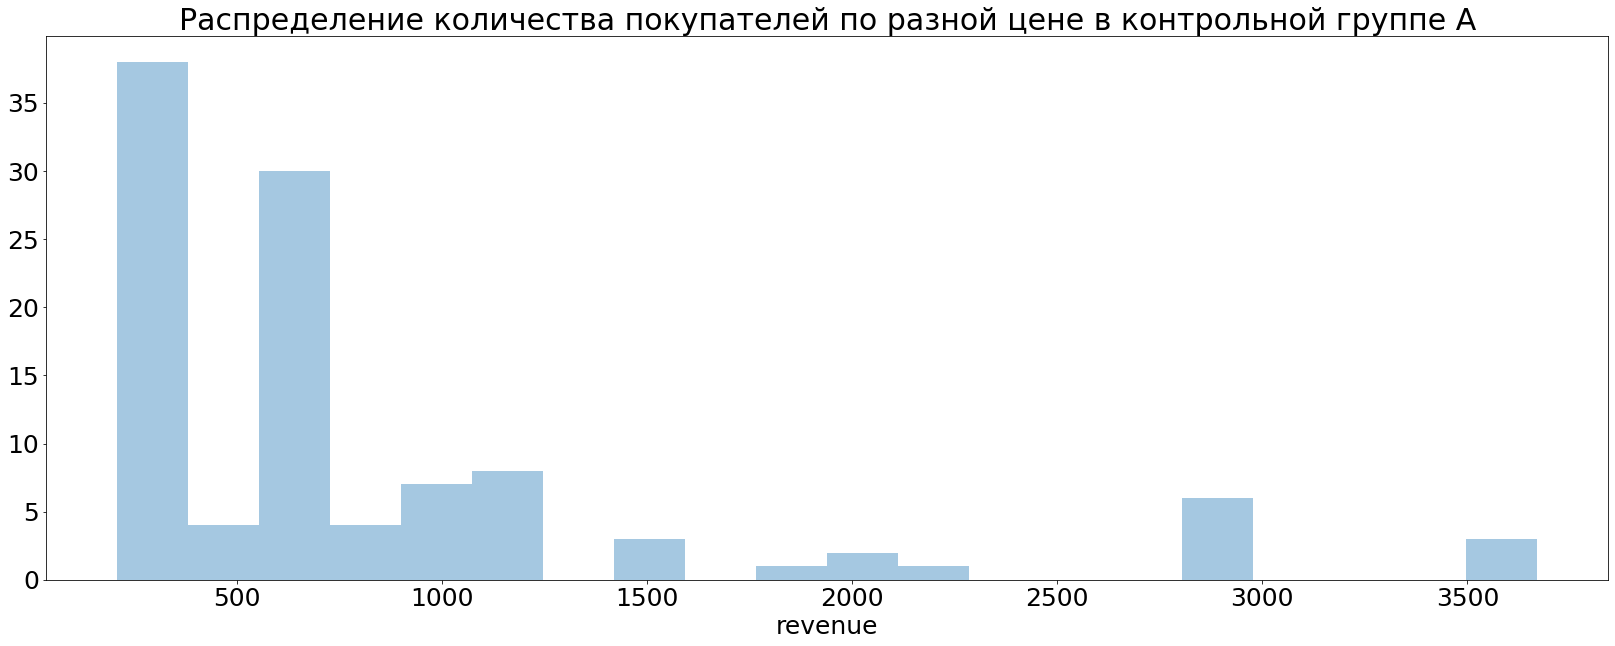

In [163]:
#Распределение чеков для группы А. Распределение ненормально
font = {'family': 'normal', 'size':'25'}
plt.rc('font',**font)
plt.figure(figsize=(28,10))
ax1=sns.distplot(purchases_A.revenue,\
             kde=False,\
             bins=20)
ax1.set_title('Распределение количества покупателей по разной цене в контрольной группе А')

Text(0.5, 1.0, 'Логарифмированное распределение числа покупателей по разной цене в контрольной группе А')

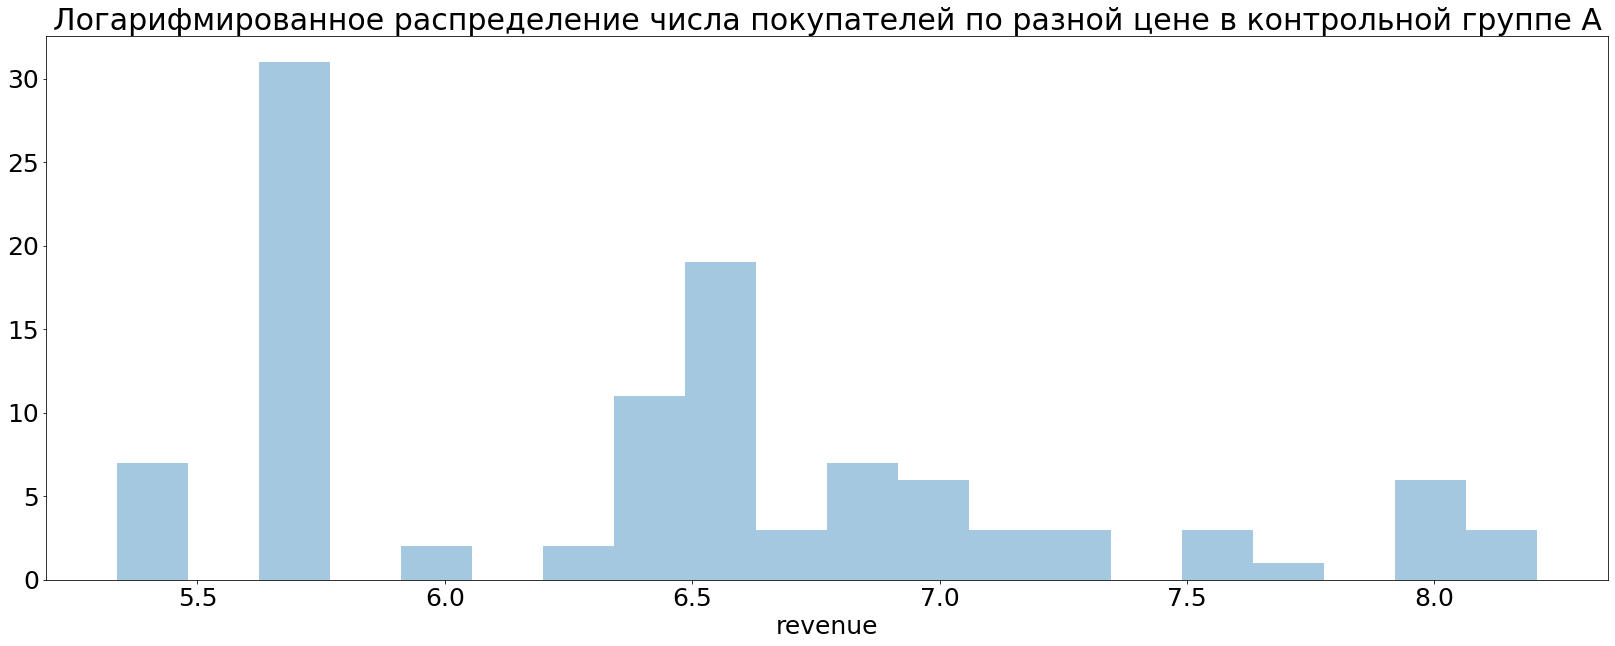

In [164]:
#Логарифмированное распределение чеков для группы А. Распределение ненормально
plt.figure(figsize=(28,10))
ax2=sns.distplot(np.log(purchases_A.revenue),\
             kde=False,\
             bins=20)
ax2.set_title('Логарифмированное распределение числа покупателей по разной цене в контрольной группе А')

Text(0.5, 1.0, 'Распределение количества покупателей по разной цене в контрольной группе B')

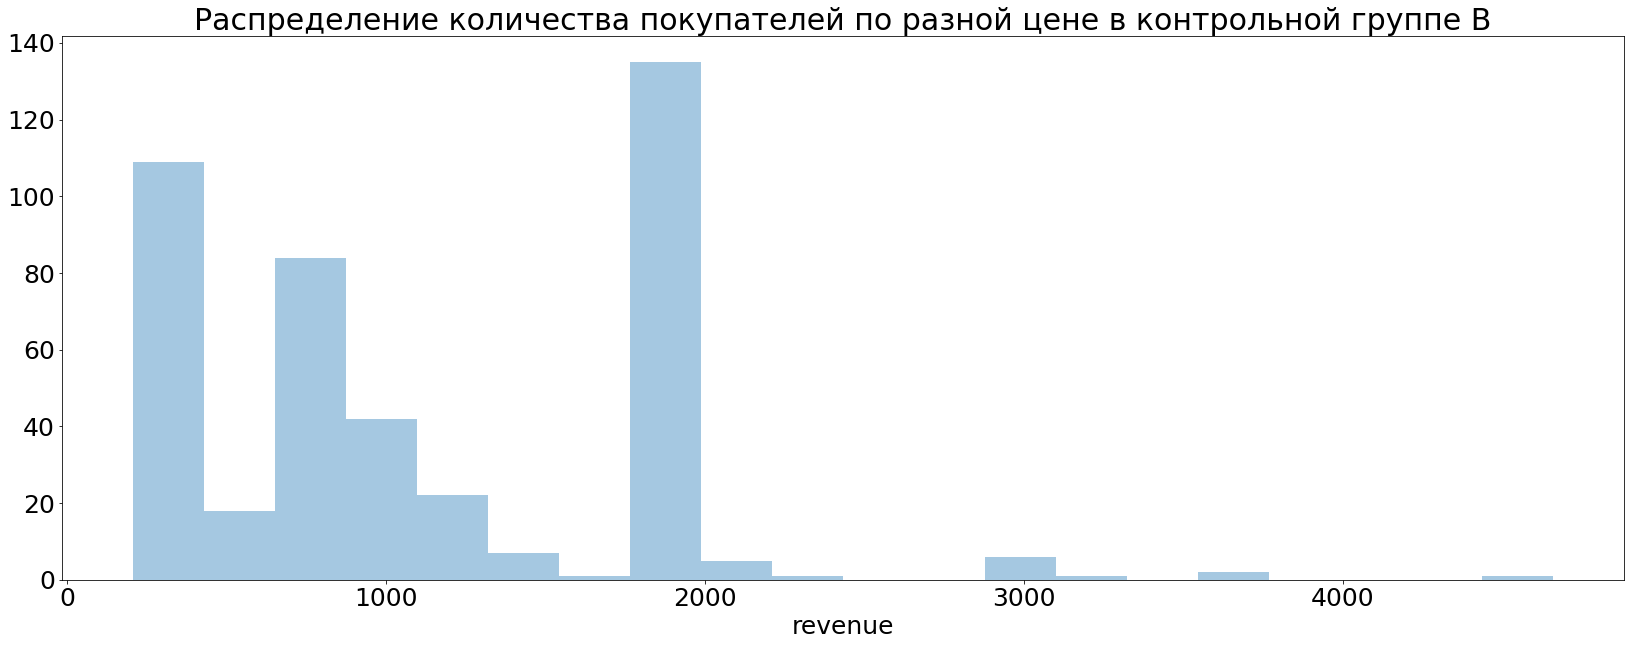

In [165]:
#Распределение чеков для группы В. Распределение ненормально
plt.figure(figsize=(28,10))
ax3=sns.distplot(purchases_B.revenue,\
             kde=False,\
             bins=20)
ax3.set_title('Распределение количества покупателей по разной цене в контрольной группе B')

Text(0.5, 1.0, 'Логарифмированное распределение числа покупателей по разной цене в контрольной группе B')

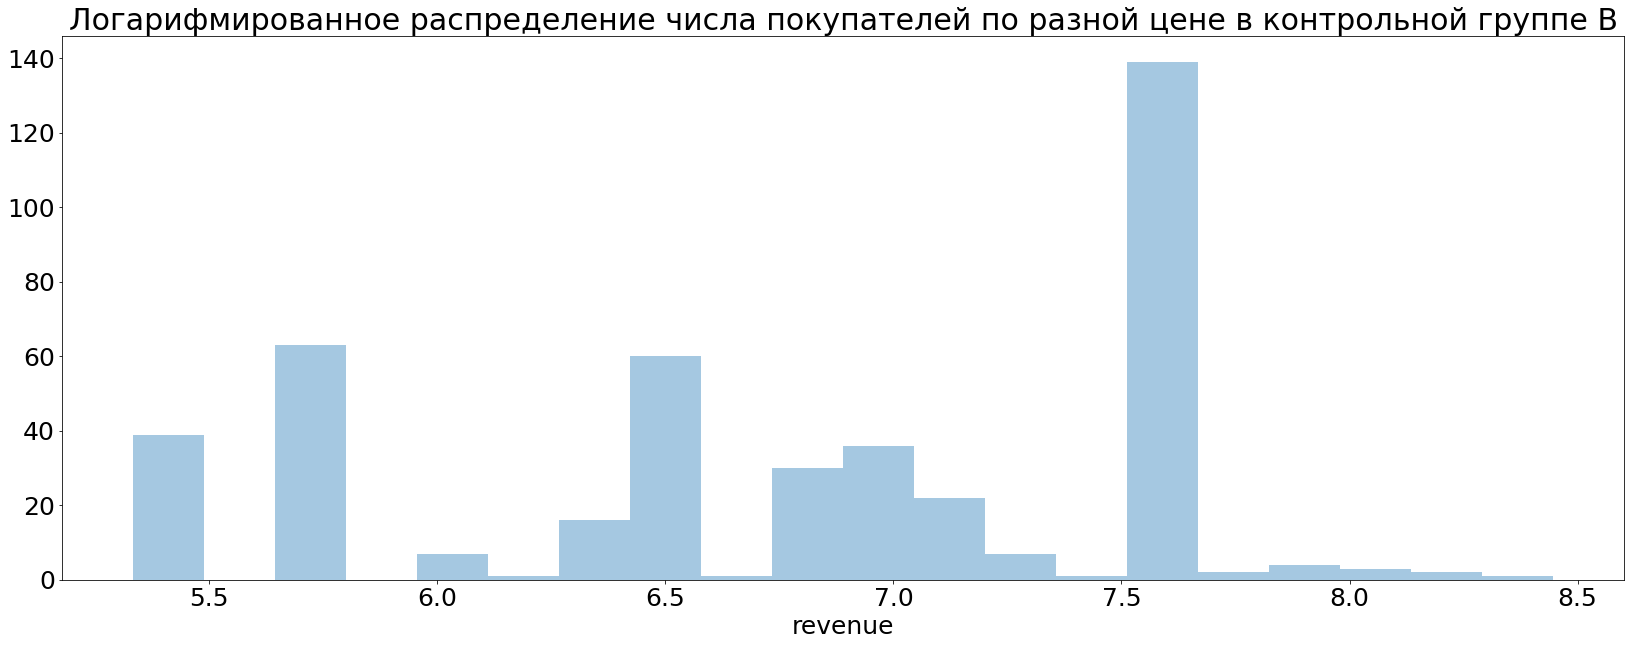

In [166]:
#Логарифмированное распределение чеков для группы B. Распределение ненормально
plt.figure(figsize=(28,10))
ax4=sns.distplot(np.log(purchases_B.revenue),\
             kde=False,\
             bins=20)
ax4.set_title('Логарифмированное распределение числа покупателей по разной цене в контрольной группе B')

Группы не удовлетворяют статистическим параметрам, а значит t-критерий Стьюдента использовать нельзя.
В таком случае будет использоваться критерий Мана-Уитни, для которого не нужно удовлетворение условий гомогенности дисперсий и нормальности распределений.

Использование критерия для выборок обосновывается тем, что у одинаковых выборок будут одинаковые средние значения, а значит статистические различия в выборках будут означать статистически значимые различия в средних для каждой выборки.

Нулевая гипотеза критерия Мана-Уитни: 
новая модель оплаты коллекций шаблонов для пользователей не влияет на изменение ARPPU.

In [167]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(purchases_A.revenue, purchases_B.revenue)

MannwhitneyuResult(statistic=17699.5, pvalue=0.0001364710277394854)

По непараметрическому критерию Мана-Уитни pvalue<0.05, а значит группы
статистически значимо различаются в 95% случаев.
Среднее значение каждой группы стоимостей покупок явлляется значением ARPPU.

Раз группы отличаются, то и средние значения групп отличаются, и значения ARPPU  также отличаются статистически значимо.
это значит, что после изменения модели оплаты изменился ARPPU  статзначимо

In [168]:
#покупки только пользователями из России
purchases_A_B_rassia.head(3)
purchases_A_B_rassia.shape

(240, 8)

In [169]:
#покупки только пользователями из России группы А
purchases_A_rassia=purchases_A_B_rassia.query('group_x=="A"')
purchases_A_rassia.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
10,4412,A,Russia,android,female,1000.0,True,A
12,4770,A,Russia,android,male,998.0,True,A
13,6182,A,Russia,android,male,600.0,True,A


In [170]:
#покупки только пользователями из России группы В
purchases_B_rassia=purchases_A_B_rassia.query('group_x=="B"')
purchases_B_rassia.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,4455,B,Russia,android,female,599.0,True,B
1,5505,B,Russia,android,male,299.0,True,B
2,6163,B,Russia,ios,male,302.0,True,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп  пользователей из России с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей из России не влияет на изменение ARPPU.

In [171]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(purchases_A_rassia.revenue, purchases_B_rassia.revenue)

MannwhitneyuResult(statistic=2925.5, pvalue=0.0014699816493472517)

По непараметрическому критерию Мана-Уитни pvalue<0.05, а значит группы с пользователями только из России статистически значимо различаются в 95% случаев. 
Среднее значение каждой группы стоимостей покупок явлляется значением ARPPU.

Раз группы отличаются, то и средние значения групп отличаются, и значения ARPPU также отличаются статистически значимо. это значит, что после изменения модели оплаты для пользователей из России изменился ARPPU статзначимо 


Проверим есть ли различия в группах А и В для пользователей из России

In [172]:
#покупки только пользователями из Швеции
purchases_A_B_sweden.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,6473,B,Sweden,ios,female,3050.0,True,B
1,2814,B,Sweden,android,female,300.0,True,B
2,1673,A,Sweden,android,male,2899.0,True,A


In [173]:
#покупки только пользователями из Швеции группы А
purchases_A_sweden=purchases_A_B_sweden.query('group_x=="A"')
purchases_A_sweden.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
2,1673,A,Sweden,android,male,2899.0,True,A
6,5626,A,Sweden,android,male,208.0,True,A
9,4697,A,Sweden,ios,male,300.0,True,A


In [174]:
#покупки только пользователями из Швеции группы В
purchases_B_sweden=purchases_A_B_sweden.query('group_x=="B"')
purchases_B_sweden.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,6473,B,Sweden,ios,female,3050.0,True,B
1,2814,B,Sweden,android,female,300.0,True,B
3,7545,B,Sweden,android,male,299.0,True,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп  пользователей из Швеции с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей из Швеции не влияет на изменение ARPPU.

In [175]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(purchases_A_sweden.revenue, purchases_B_sweden.revenue)

MannwhitneyuResult(statistic=1577.5, pvalue=0.03958280081671394)

По непараметрическому критерию Мана-Уитни pvalue<0.05, а значит группы с пользователями только из Швеции статистически значимо различаются в 95% случаев. Среднее значение каждой группы стоимостей покупок явлляется значением ARPPU.

Раз группы отличаются, то и средние значения групп отличаются, и значения ARPPU также отличаются статистически значимо. это значит, что после изменения модели оплаты для пользователей из Швеции изменился ARPPU статзначимо


Проверим есть ли различия в группах А и В для пользователей Android

In [176]:
#покупки только пользователями Android
purchases_A_B_android.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,4455,B,Russia,android,female,599.0,True,B
1,2814,B,Sweden,android,female,300.0,True,B
2,1673,A,Sweden,android,male,2899.0,True,A


In [177]:
#покупки только пользователями Android группы А
purchases_A_android=purchases_A_B_android.query('group_x=="A"')
purchases_A_android.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
2,1673,A,Sweden,android,male,2899.0,True,A
7,5626,A,Sweden,android,male,208.0,True,A
13,4412,A,Russia,android,female,1000.0,True,A


In [178]:
#покупки только пользователями Android группы B
purchases_B_android=purchases_A_B_android.query('group_x=="B"')
purchases_B_android.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,4455,B,Russia,android,female,599.0,True,B
1,2814,B,Sweden,android,female,300.0,True,B
3,5505,B,Russia,android,male,299.0,True,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей Android с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей Android не влияет на изменение ARPPU.

In [179]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(purchases_A_android.revenue, purchases_B_android.revenue)

MannwhitneyuResult(statistic=2630.0, pvalue=0.04925014637316891)

По непараметрическому критерию Мана-Уитни pvalue<0.05, а значит группы с пользователями Android статистически значимо различаются в 95% случаев. Среднее значение каждой группы стоимостей покупок явлляется значением ARPPU.

Раз группы отличаются, то и средние значения групп отличаются, и значения ARPPU также отличаются статистически значимо. это значит, что после изменения модели оплаты для пользователей Android изменился ARPPU статзначимо


Проверим есть ли различия в группах А и В для пользователей IoS

In [180]:
#покупки только пользователями Ios
purchases_A_B_ios.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,6473,B,Sweden,ios,female,3050.0,True,B
1,7873,B,Sweden,ios,male,890.0,True,B
2,6163,B,Russia,ios,male,302.0,True,B


In [181]:
#покупки только пользователями IoS группы А
purchases_A_ios=purchases_A_B_ios.query('group_x=="A"')
purchases_A_ios.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
6,4697,A,Sweden,ios,male,300.0,True,A
12,8025,A,Russia,ios,female,2921.0,True,A
15,7950,A,Russia,ios,male,3669.0,True,A


In [182]:
#покупки только пользователями IoS группы B
purchases_B_ios=purchases_A_B_ios.query('group_x=="B"')
purchases_B_ios.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,6473,B,Sweden,ios,female,3050.0,True,B
1,7873,B,Sweden,ios,male,890.0,True,B
2,6163,B,Russia,ios,male,302.0,True,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей IoS с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей IoS не влияет на изменение ARPPU.

In [183]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(purchases_A_ios.revenue, purchases_B_ios.revenue)

MannwhitneyuResult(statistic=1893.5, pvalue=0.0015426543641399385)

По непараметрическому критерию Мана-Уитни pvalue<0.05, а значит группы с пользователями IoS статистически значимо различаются в 95% случаев. Среднее значение каждой группы стоимостей покупок явлляется значением ARPPU.

Раз группы отличаются, то и средние значения групп отличаются, и значения ARPPU также отличаются статистически значимо. это значит, что после изменения модели оплаты для пользователей IoS изменился ARPPU статзначимо


Проверим есть ли различия в группах А и В для пользователей мужского пола

In [184]:
#покупки только пользователями мужского пола
purchases_A_B_male.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,1673,A,Sweden,android,male,2899.0,True,A
1,5505,B,Russia,android,male,299.0,True,B
2,7545,B,Sweden,android,male,299.0,True,B


In [185]:
#покупки только пользователями мужского пола группы А
purchases_A_male=purchases_A_B_male.query('group_x=="A"')
purchases_A_male.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,1673,A,Sweden,android,male,2899.0,True,A
6,5626,A,Sweden,android,male,208.0,True,A
10,4697,A,Sweden,ios,male,300.0,True,A


In [186]:
#покупки только пользователями мужского пола группы В
purchases_B_male=purchases_A_B_male.query('group_x=="B"')
purchases_B_male.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
1,5505,B,Russia,android,male,299.0,True,B
2,7545,B,Sweden,android,male,299.0,True,B
3,7873,B,Sweden,ios,male,890.0,True,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей мужского пола с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей мужского пола не влияет на изменение ARPPU.

In [187]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(purchases_A_male.revenue, purchases_B_male.revenue)

MannwhitneyuResult(statistic=2663.0, pvalue=0.06326402745293058)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы с пользователями мужского пола статистически значимо не различаются в 95% случаев. Среднее значение каждой группы стоимостей покупок явлляется значением ARPPU.

Раз группы не отличаются, то в средних значениях групп не удалось найти различия. Стат значимых изменений в ARPPU для пользователей мужского пола с 95% вероятностью найти не удалось.

Проверим есть ли различия в группах А и В для пользователей женского пола

In [188]:
#покупки только пользователями женского пола
purchases_A_B_female.head(3)

,user_id,group_x,country,platform,sex,revenue,Buying,group_y
0,4455,B,Russia,android,female,599.0,True,B
1,6473,B,Sweden,ios,female,3050.0,True,B
2,2814,B,Sweden,android,female,300.0,True,B


In [299]:
#покупки только пользователями женского пола группы А
purchases_A_female=purchases_A_B_female.query('group_x=="A"')
purchases_A_female.shape

(37, 8)

In [300]:
#покупки только пользователями женского пола группы В
purchases_B_female=purchases_A_B_female.query('group_x=="B"')
purchases_B_female.shape

(154, 8)

Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей женского пола с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей женского пола не влияет на изменение ARPPU.

In [191]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(purchases_A_female.revenue, purchases_B_female.revenue)

MannwhitneyuResult(statistic=1841.0, pvalue=0.0008191912980826493)

По непараметрическому критерию Мана-Уитни pvalue<0.05, а значит группы с пользователями женского пола статистически значимо различаются в 95% случаев. Среднее значение каждой группы стоимостей покупок явлляется значением ARPPU.

Раз группы отличаются, то и средние значения групп отличаются, и значения ARPPU также отличаются статистически значимо. это значит, что после изменения модели оплаты для пользователей женского пола изменился ARPPU статзначимо



Вывод: с 95% вероятностью после изменения оплаты пользователей ARPPU изменился статзначимо.

В отдельности, с 95% вероятностью для пользователей Android, IoS, пользователей из России или Швеции, а также для женщин ARPPU изменился статзначимо. 

Для пользователей мужского пола с 95% вероятностью не было обнаружено статзначимых изменений.


# Проверка наличия статистически значимых различий в ARPU

ARPU=доход/общее количество пользователей.

Иными словами ARPU можно найти как среднее значение из всех покупок пользователей, даже если пользователь ничего не купил (revenue = 0)

In [192]:
full_data.head(3)
#В full_data есть данные о всех пользователях и о покупках

,user_id,country,platform,sex,revenue,group
0,8029,Russia,ios,male,0.0,B
1,1735,Sweden,ios,male,0.0,B
2,7697,Russia,android,male,0.0,B


In [240]:
# датасет со всеми данными, где пользователи без покупок имеют revenue = 0 
data_for_ARPU=full_data.merge(groups, on='user_id')
data_for_ARPU.head(3)


,user_id,country,platform,sex,revenue,Buying,group
0,8029,Russia,ios,male,0.0,NaN,B
1,1735,Sweden,ios,male,0.0,NaN,B
2,7697,Russia,android,male,0.0,NaN,B


In [241]:
# отбор пользователей для из группы А
data_for_ARPU_A=data_for_ARPU.query('group=="A"')
data_for_ARPU_A.head(3)
data_for_ARPU_A.shape

(1538, 7)

In [242]:
# отбор пользователей для из группы В
data_for_ARPU_B=data_for_ARPU.query('group=="B"')
data_for_ARPU_B.head(3)
data_for_ARPU_B.shape

(6803, 7)

In [243]:
# нахождение значение ARPU для группы А
data_for_ARPU_A.revenue.mean()

47.853055916775034

In [244]:
# нахождение значение ARPU для группы В
data_for_ARPU_B.revenue.mean()

58.520211671321476

Проверка на удовлетворение выборок параметрическим критериям

In [245]:
ss.levene(data_for_ARPU_A.revenue, data_for_ARPU_B.revenue)
# дисперсии гомогенны

LeveneResult(statistic=1.4725553042744919, pvalue=0.22497732609218005)

In [246]:
#дисперсии совпадают статистически значимо 

In [247]:
ss.normaltest(data_for_ARPU_A.revenue)

NormaltestResult(statistic=2233.9907236555932, pvalue=0.0)

In [248]:
ss.normaltest(data_for_ARPU_B.revenue)

NormaltestResult(statistic=7782.7510530379, pvalue=0.0)

In [249]:
#Выборки ненормальные. t-тест примеять нельзя, так как не выполняются условия для его проведения

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


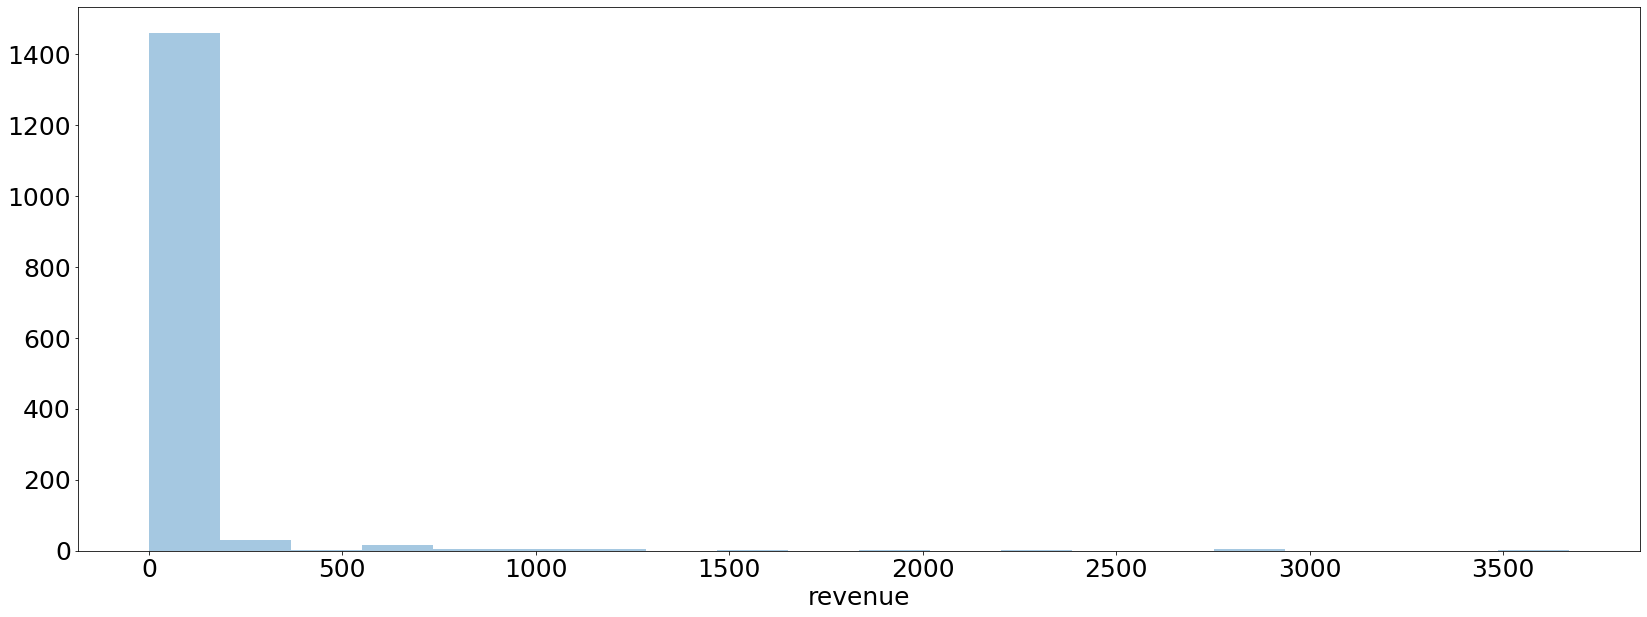

In [250]:
#действительно, видно, что распределение А ненормальное
plt.figure(figsize=(28,10))
sns.distplot(data_for_ARPU_A.revenue, \
             kde=False,\
             bins=20)

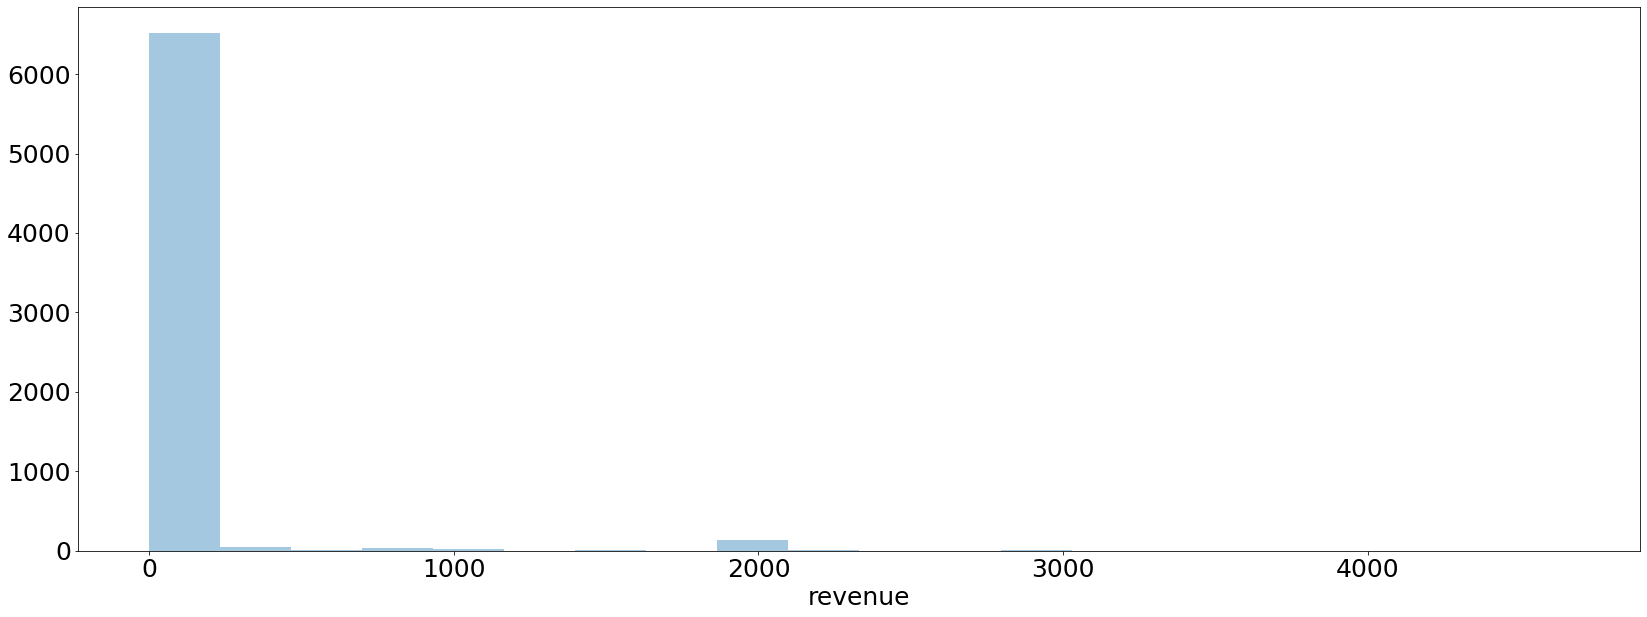

In [251]:
#действительно, видно, что распределение В ненормальное
plt.figure(figsize=(28,10))
sns.distplot(data_for_ARPU_B.revenue,\
             kde=False, \
             bins=20)

In [252]:
#В распределении много нулей, поэтому логарифмирование не помогает

Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей не влияет на изменение ARPU.

In [253]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(data_for_ARPU_A.revenue, data_for_ARPU_B.revenue)

MannwhitneyuResult(statistic=5252073.0, pvalue=0.5107994153653242)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы
статистически значимо не различаются в 95% случаев.

Среднее значение каждой группы стоимостей покупок явлляется значением ARPU.

Раз группы не отличаются, то и значения ARPU  также не отличаются статистически значимо.
Это значит, что после изменения модели оплаты  ARPPU  статзначимо не изменился.

Проверим есть ли различия в группах А и В для пользователей из России

In [254]:
#отбор пользователей из России для группы А 
data_for_ARPU_A_Russia=data_for_ARPU_A.query('country=="Russia"')
data_for_ARPU_A_Russia.head(3)

,user_id,country,platform,sex,revenue,Buying,group
8,4038,Russia,android,female,0.0,NaN,A
23,518,Russia,android,female,0.0,NaN,A
27,5220,Russia,ios,male,0.0,NaN,A


In [255]:
#отбор пользователей из России для группы В
data_for_ARPU_B_Russia=data_for_ARPU_B.query('country=="Russia"')
data_for_ARPU_B_Russia.head(3)

,user_id,country,platform,sex,revenue,Buying,group
0,8029,Russia,ios,male,0.0,NaN,B
2,7697,Russia,android,male,0.0,NaN,B
4,1704,Russia,ios,male,0.0,NaN,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей из России с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей из России не влияет на изменение ARPU.

In [256]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(data_for_ARPU_A_Russia.revenue, data_for_ARPU_B_Russia.revenue)

MannwhitneyuResult(statistic=2060230.5, pvalue=0.7378679663866102)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы пользователей из России статистически значимо не различаются в 95% случаев.

Среднее значение каждой группы стоимостей покупок явлляется значением ARPU.

Раз группы не отличаются, то и значения ARPU также не отличаются статистически значимо пользователей из России. Это значит, что после изменения модели оплаты ARPPU статзначимо не изменился для пользователей из России.

Проверим есть ли различия в группах А и В для пользователей из Швеции

In [257]:
#отбор пользователей из Швеции для группы А 
data_for_ARPU_A_Sweden=data_for_ARPU_A.query('country=="Sweden"')
data_for_ARPU_A_Sweden.head(3)

,user_id,country,platform,sex,revenue,Buying,group
11,2427,Sweden,android,female,0.0,NaN,A
22,6772,Sweden,android,female,0.0,NaN,A
45,1202,Sweden,android,male,302.0,True,A


In [ ]:
#отбор пользователей из Швеции для группы В
data_for_ARPU_B_Sweden=data_for_ARPU_B.query('country=="Sweden"')
data_for_ARPU_B_Sweden.head(3)

Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей из Швеции с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей из Швеции не влияет на изменение ARPU.

In [ ]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(data_for_ARPU_A_Sweden.revenue, data_for_ARPU_B_Sweden.revenue)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы пользователей из Швеции статистически значимо не различаются в 95% случаев.

Среднее значение каждой группы стоимостей покупок явлляется значением ARPU.

Раз группы не отличаются, то и значения ARPU также не отличаются статистически значимо пользователей из Швеции. Это значит, что после изменения модели оплаты ARPPU статзначимо не изменился для пользователей из Швеции.

Проверим есть ли различия в группах А и В для пользователей Android

In [ ]:
#отбор пользователей Android для группы А 
data_for_ARPU_A_Android=data_for_ARPU_A.query('platform=="android"')
data_for_ARPU_A_Android.head(3)

In [258]:
#отбор пользователей Android для группы B
data_for_ARPU_B_Android=data_for_ARPU_B.query('platform=="android"')
data_for_ARPU_B_Android.head(3)

,user_id,country,platform,sex,revenue,Buying,group
2,7697,Russia,android,male,0.0,NaN,B
3,1421,Sweden,android,female,0.0,NaN,B
6,8324,Sweden,android,male,0.0,NaN,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей Android с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей Android не влияет на изменение ARPU.

In [ ]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(data_for_ARPU_A_Android.revenue, data_for_ARPU_B_Android.revenue)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы пользователей Android статистически значимо не различаются в 95% случаев.

Среднее значение каждой группы стоимостей покупок явлляется значением ARPU.

Раз группы не отличаются, то и значения ARPU также не отличаются статистически значимо пользователей Android. Это значит, что после изменения модели оплаты ARPPU статзначимо не изменился для пользователей Android.

Проверим есть ли различия в группах А и В для пользователей IoS

In [259]:
#отбор пользователей IoS для группы А 
data_for_ARPU_A_ios=data_for_ARPU_A.query('platform=="ios"')
data_for_ARPU_A_ios.head(3)

,user_id,country,platform,sex,revenue,Buying,group
27,5220,Russia,ios,male,0.0,NaN,A
57,8224,Russia,ios,female,0.0,NaN,A
61,756,Russia,ios,male,0.0,NaN,A


In [260]:
#отбор пользователей IoS для группы B
data_for_ARPU_B_ios=data_for_ARPU_B.query('platform=="ios"')
data_for_ARPU_B_ios.head(3)

,user_id,country,platform,sex,revenue,Buying,group
0,8029,Russia,ios,male,0.0,NaN,B
1,1735,Sweden,ios,male,0.0,NaN,B
4,1704,Russia,ios,male,0.0,NaN,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей IoS с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей IoS не влияет на изменение ARPU.

In [261]:
mannwhitneyu(data_for_ARPU_A_ios.revenue, data_for_ARPU_B_ios.revenue)

MannwhitneyuResult(statistic=1068470.0, pvalue=0.47818109352550153)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы пользователей IoS статистически значимо не различаются в 95% случаев.

Среднее значение каждой группы стоимостей покупок явлляется значением ARPU.

Раз группы не отличаются, то и значения ARPU также не отличаются статистически значимо пользователей IoS. Это значит, что после изменения модели оплаты ARPPU статзначимо не изменился для пользователей IoS.

Проверим есть ли различия в группах А и В для пользователей мужского пола

In [262]:
#отбор пользователей мужского пола для группы А 
data_for_ARPU_A_male=data_for_ARPU_A.query('sex=="male"')
data_for_ARPU_A_male.head(3)

,user_id,country,platform,sex,revenue,Buying,group
27,5220,Russia,ios,male,0.0,NaN,A
37,2021,Russia,android,male,0.0,NaN,A
45,1202,Sweden,android,male,302.0,True,A


In [263]:
#отбор пользователей мужского пола для группы В
data_for_ARPU_B_male=data_for_ARPU_B.query('sex=="male"')
data_for_ARPU_B_male.head(3)

,user_id,country,platform,sex,revenue,Buying,group
0,8029,Russia,ios,male,0.0,NaN,B
1,1735,Sweden,ios,male,0.0,NaN,B
2,7697,Russia,android,male,0.0,NaN,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей мужского пола с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей мужского пола не влияет на изменение ARPU.

In [264]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(data_for_ARPU_A_male.head(3).revenue, data_for_ARPU_B_male.head(3).revenue)

MannwhitneyuResult(statistic=6.0, pvalue=0.5049850750938458)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы пользователей мужского пола статистически значимо не различаются в 95% случаев.

Среднее значение каждой группы стоимостей покупок явлляется значением ARPU.

Раз группы не отличаются, то и значения ARPU также не отличаются статистически значимо пользователей мужского пола. Это значит, что после изменения модели оплаты ARPPU статзначимо не изменился для пользователей мужского пола.

Проверим есть ли различия в группах А и В для пользователей женского пола

In [297]:
#отбор пользователей женского пола для группы А 
data_for_ARPU_A_female=data_for_ARPU_A.query('sex=="female"')
data_for_ARPU_A_female.shape

(753, 7)

In [266]:
#отбор пользователей женского пола для группы В 
data_for_ARPU_B_female=data_for_ARPU_B.query('sex=="female"')
data_for_ARPU_B_female.head(3)

,user_id,country,platform,sex,revenue,Buying,group
3,1421,Sweden,android,female,0.0,NaN,B
5,4788,Russia,ios,female,0.0,NaN,B
7,7654,Russia,ios,female,0.0,NaN,B


Далее необходимо произвести сравнение выборок стоимостей покупок для А и В групп пользователей женского пола с помощью критерия Мана-Уитни.

Нулевая гипотеза критерия Мана-Уитни: новая модель оплаты коллекций шаблонов для пользователей женского пола не влияет на изменение ARPU.

In [267]:
#Проверка чеков групп по критерию Мана-Уитни.
mannwhitneyu(data_for_ARPU_A_female.revenue, data_for_ARPU_B_female.revenue)

MannwhitneyuResult(statistic=1280851.0, pvalue=0.7273483841651485)

По непараметрическому критерию Мана-Уитни pvalue>0.05, а значит группы пользователей женского пола статистически значимо не различаются в 95% случаев.

Среднее значение каждой группы стоимостей покупок явлляется значением ARPU.

Раз группы не отличаются, то и значения ARPU также не отличаются статистически значимо пользователей женского пола. Это значит, что после изменения модели оплаты ARPPU статзначимо не изменился для пользователей женского пола.

Вывод: с 95% вероятностью после изменения оплаты пользователей ARPU не изменился статзначимо.

В отдельности, с 95% вероятностью для всех категорий пользователей статзначимых изменений в ARPU не было обнаружено.



# Вывод


1). С вероятностью в 95%  С верояностью в 95% не удалось установить статистически значимых различий в конверсии в покупку между оплатой покупки старым и новым способами. У различных групп пользователей также не удалось это установить.

2). Изменения метода оплаты не повлияло на коэффициент повторных покупок

3). с 95% вероятностью после изменения оплаты пользователей ARPPU изменился статзначимо.

В отдельности, с 95% вероятностью для пользователей Android, IoS, пользователей из России или Швеции, а также для женщин ARPPU изменился статзначимо.

Для пользователей мужского пола с 95% вероятностью не было обнаружено статзначимых изменений.

4). С 95% вероятностью после изменения оплаты пользователей ARPU не изменился статзначимо.

В отдельности, с 95% вероятностью для всех категорий пользователей статзначимых изменений в ARPU не было обнаружено.

# Проведем анализ причин изменения ARPPU в тестовой группе

In [412]:
purchases_A.head(3)

,user_id,revenue,Buying,group
0,4412,1000.0,True,A
9,9006,699.0,True,A
16,9013,699.0,True,A


In [414]:
purchases_B.shape

(434, 4)

In [270]:
#топ 10 цен товаров, по которым покупали чаще всего в группе А
top_A=purchases_A.groupby('revenue',as_index=False)\
           .agg({'user_id':'count'})\
           .sort_values('user_id', ascending = False)\
           .head(10)\
           .rename(columns={'user_id':'count_of_users'})
top_A

,revenue,count_of_users
4,300.0,10
5,301.0,8
18,700.0,8
17,699.0,6
3,299.0,6
0,208.0,5
2,298.0,4
15,600.0,4
6,302.0,3
12,590.0,3


In [271]:
#топ 10 цен товаров, по которым покупали чаще всего в группе В
top_B=purchases_B.groupby('revenue',as_index=False)\
           .agg({'user_id':'count'})\
           .sort_values('user_id', ascending = False)\
           .head(10)\
           .rename(columns={'user_id':'count_of_users'})
top_B

,revenue,count_of_users
63,1910.0,50
62,1909.0,34
64,1911.0,28
7,300.0,20
8,301.0,20
27,700.0,20
2,209.0,20
28,701.0,19
26,699.0,13
6,299.0,12


In [272]:
#процент товаров с ценами 1910, 1909, 1911 от общего числа покупок в группе В
(50+34+28)/434

0.25806451612903225

Text(0.5, 1.0, 'Топ-10 по количеству покупателей по разной цене в контрольной группе А')

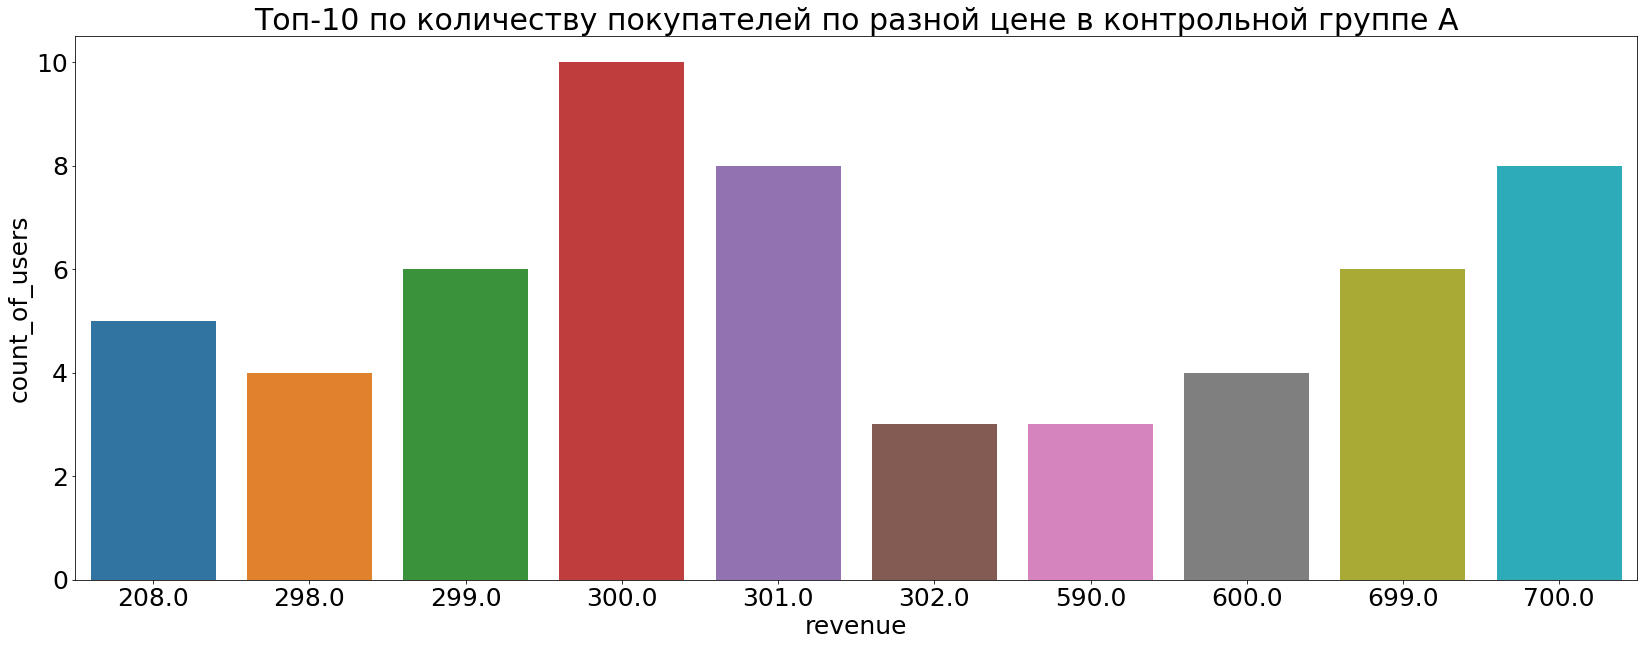

In [273]:
#бар плот топ-10 по количеству покупателей по разной цене в контрольной группе А
plt.figure(figsize=(28,10))
ax = sns.barplot(x="revenue", y="count_of_users", data=top_A)
ax.set_title('Топ-10 по количеству покупателей по разной цене в контрольной группе А')

Text(0.5, 1.0, 'Топ-10 по количеству покупателей по разной цене в контрольной группе B')

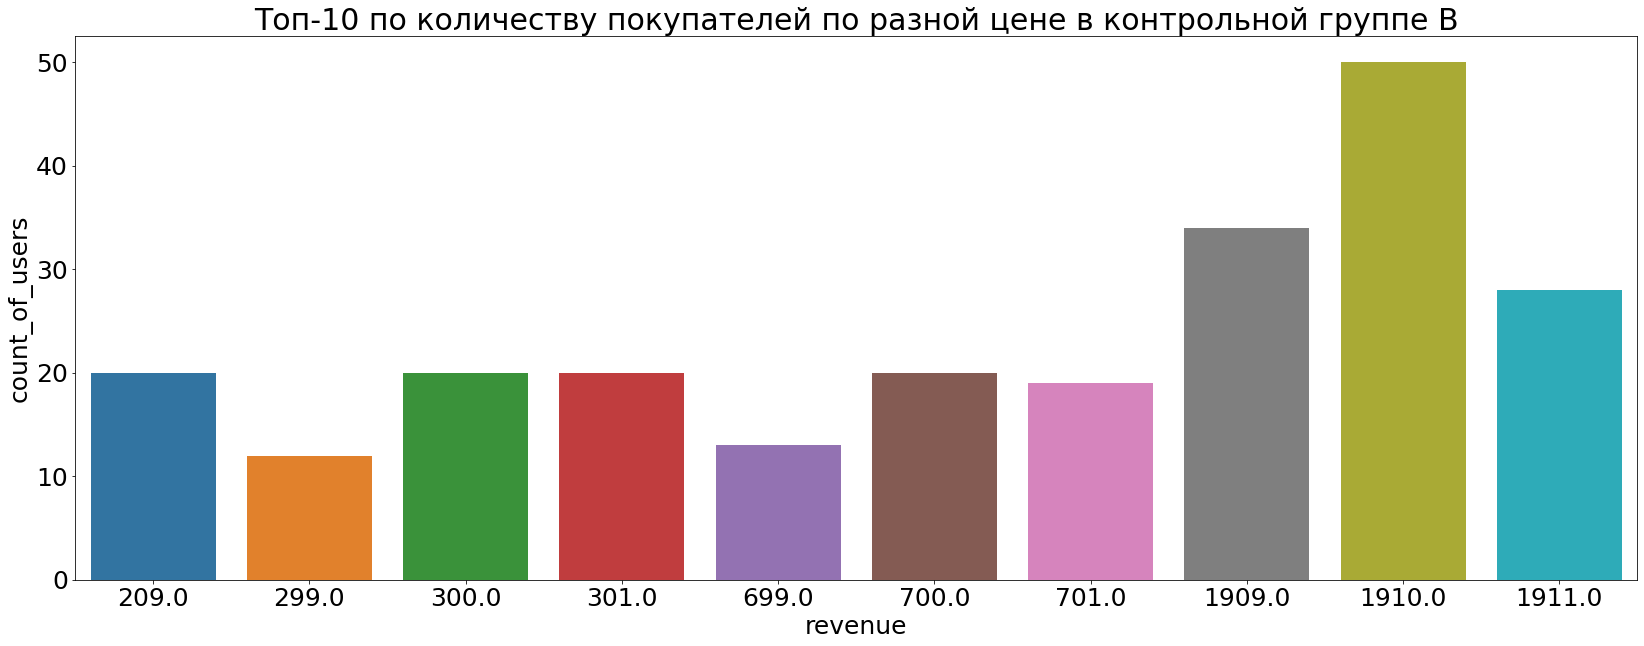

In [274]:
#бар плот топ-10 по количеству покупателей по разной цене в контрольной группе В
plt.figure(figsize=(28,10))
ax = sns.barplot(x="revenue", y="count_of_users", data=top_B)
ax.set_title('Топ-10 по количеству покупателей по разной цене в контрольной группе B')

в прежней модели оплаты чаще всего покупались товары с ценой 300, в то время как в новой модели чаще всего покупались товары с ценой 1910.
В группе А не было не одной покупки по ценам 1909, 1910, 1911, которые составляют 26% от всего количества покупок группы В. Это весомый вклад в увеличение ARPPU.


In [275]:
#проверка: были ли цены 1911, 1910, 1909 в контрольной группе: таких цен не было, а значит они появились только в тесте
purchases_A.query('revenue==1911.0')

,user_id,revenue,Buying,group


In [276]:
purchases_A.query('revenue==1910.0')

,user_id,revenue,Buying,group


In [277]:
purchases_A.query('revenue==1909.0')

,user_id,revenue,Buying,group


In [387]:
#создание датасета со всеми данными и значениями 0 там, где не было покупки у пользователя из группы А или В
full_data=full_data.merge(groups, on='user_id', how='left')
full_data

,user_id,country,platform,sex,revenue,group
0,8029,Russia,ios,male,0.0,B
1,1735,Sweden,ios,male,0.0,B
2,7697,Russia,android,male,0.0,B
3,1421,Sweden,android,female,0.0,B
4,1704,Russia,ios,male,0.0,B
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,0.0,B
8337,3755,Russia,ios,male,590.0,A
8338,4594,Sweden,android,female,0.0,B
8339,7430,Sweden,ios,female,0.0,B


In [415]:
#топ-10 по количеству покупателей по разной цене в контрольной группе A для мужчин
male_A_top_revenue=full_data.query('sex=="male" and group=="A"')\
                            .groupby('revenue', as_index=False)\
                            .agg({'user_id':"count"})\
                            .sort_values('user_id')\
                            .tail(10)\
                            .query('revenue!=0')
male_A_top_revenue

,revenue,user_id
6,302.0,1
3,299.0,1
26,3669.0,1
8,590.0,2
2,298.0,2
5,301.0,3
9,600.0,4
1,208.0,4
4,300.0,5


In [416]:
#топ-10 по количеству покупателей по разной цене в контрольной группе A для женщин
female_A_top_revenue=full_data.query('sex=="female" and group=="A"')\
                              .groupby('revenue', as_index=False)\
                              .agg({'user_id':"count"})\
                              .sort_values('user_id')\
                              .tail(10)\
                              .query('revenue!=0')
female_A_top_revenue

,revenue,user_id
1,208.0,1
11,593.0,1
9,589.0,2
16,851.0,2
17,1000.0,2
3,299.0,2
2,298.0,2
5,301.0,4
4,300.0,4


In [420]:
#топ-10 по количеству покупателей по разной цене в контрольной группе В для мужчин
male_B_top_revenue=full_data.query('sex=="male" and group=="B"')\
                            .groupby('revenue', as_index=False)\
                            .agg({'user_id':"count"})\
                            .sort_values('user_id')\
                            .tail(10)\
                            .query('revenue!=0')
male_B_top_revenue

,revenue,user_id
45,1912.0,5
2,208.0,5
7,299.0,5
9,301.0,6
41,1908.0,6
8,300.0,7
44,1911.0,16
42,1909.0,17
43,1910.0,17


In [418]:
#топ-10 по количеству покупателей по разной цене в контрольной группе В для женщин
female_B_top_revenue=full_data.query('sex=="female" and group=="B"')\
                              .groupby('revenue', as_index=False)\
                              .agg({'user_id':"count"})\
                              .sort_values('user_id')\
                              .tail(10)\
                              .query('revenue!=0')
female_B_top_revenue

,revenue,user_id
39,1912.0,5
35,1908.0,5
21,850.0,5
6,300.0,6
2,209.0,7
7,301.0,9
38,1911.0,10
36,1909.0,16
37,1910.0,31


Text(0.5, 1.0, 'Топ-10 цен товаров покупаемых женщинами в группе В ')

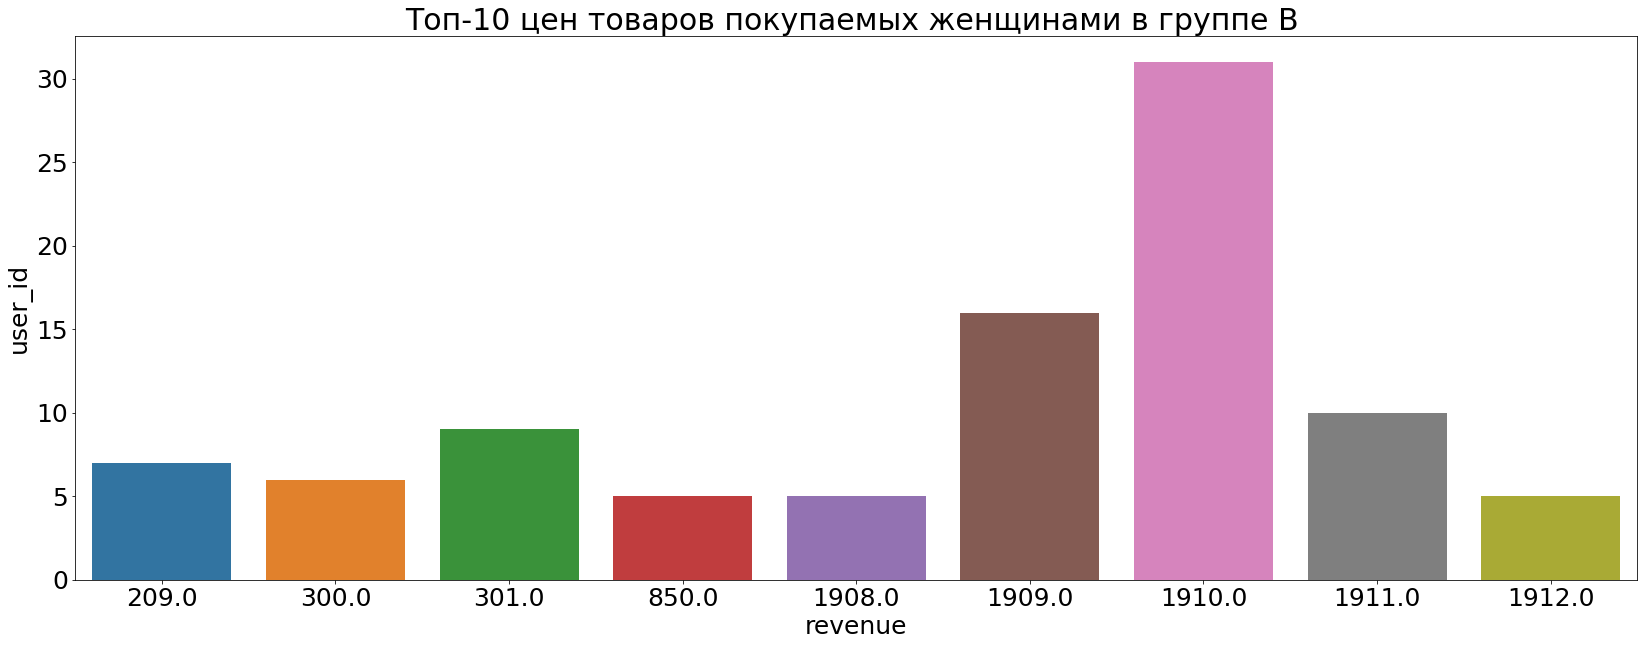

In [402]:
#бар плот топ-10 по количеству покупателей по разной цене в контрольной группе В для женщин
plt.figure(figsize=(28,10))
ax = sns.barplot(x="revenue", y="user_id", data=female_B_top_revenue)
ax.set_title('Топ-10 цен товаров покупаемых женщинами в группе В ')

Text(0.5, 1.0, 'Топ-10 цен товаров покупаемых мужчинами в группе В  ')

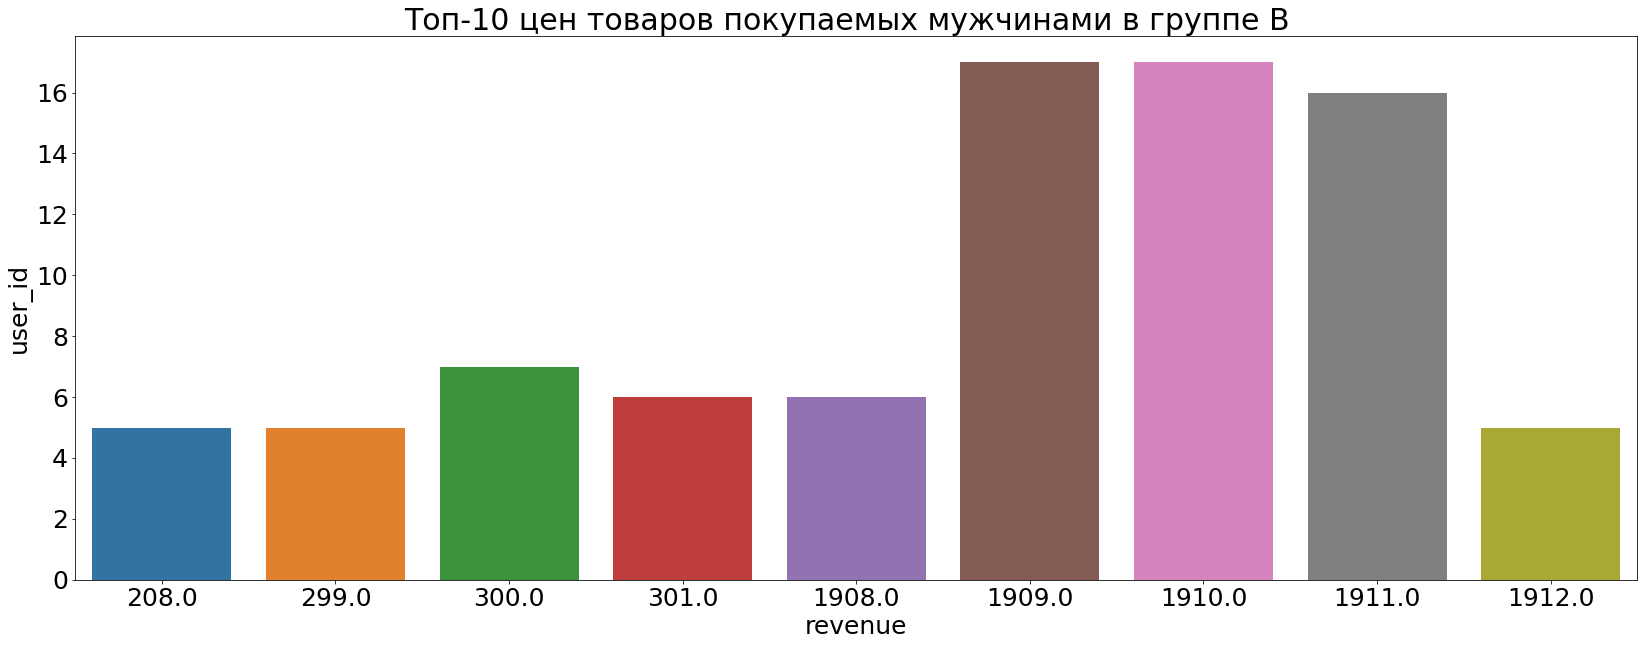

In [407]:
#бар плот топ-10 по количеству покупателей по разной цене в контрольной группе В для мужчин
plt.figure(figsize=(28,10))
ax = sns.barplot(x="revenue", y="user_id", data=male_B_top_revenue)
ax.set_title('Топ-10 цен товаров покупаемых мужчинами в группе В  ')

Text(0.5, 1.0, 'Топ-10 цен товаров покупаемых женщинами в группе А  ')

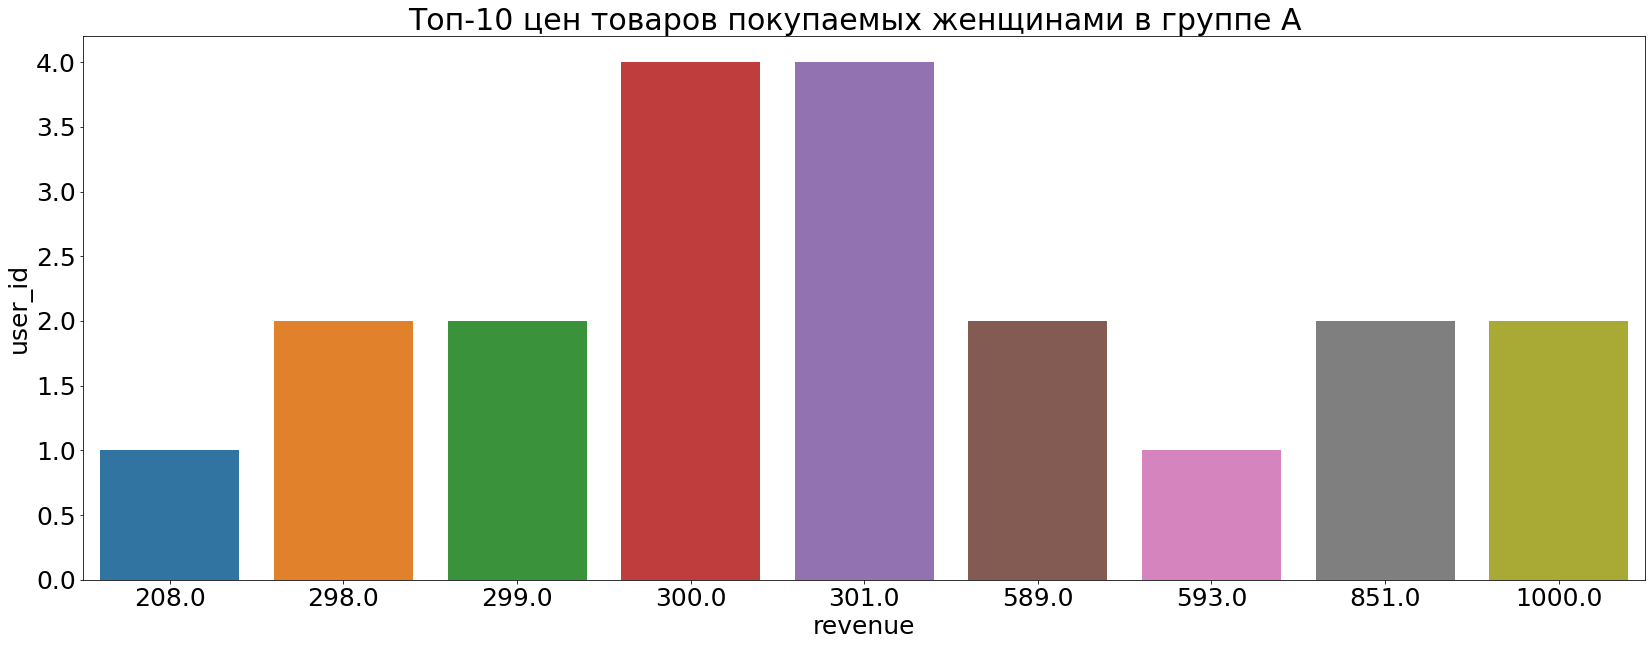

In [408]:
#бар плот топ-10 по количеству покупателей по разной цене в контрольной группе А для женщин
plt.figure(figsize=(28,10))
ax = sns.barplot(x="revenue", y="user_id", data=female_A_top_revenue)
ax.set_title('Топ-10 цен товаров покупаемых женщинами в группе А  ')

Text(0.5, 1.0, 'Топ-10 цен товаров покупаемых мужчинами в группе A  ')

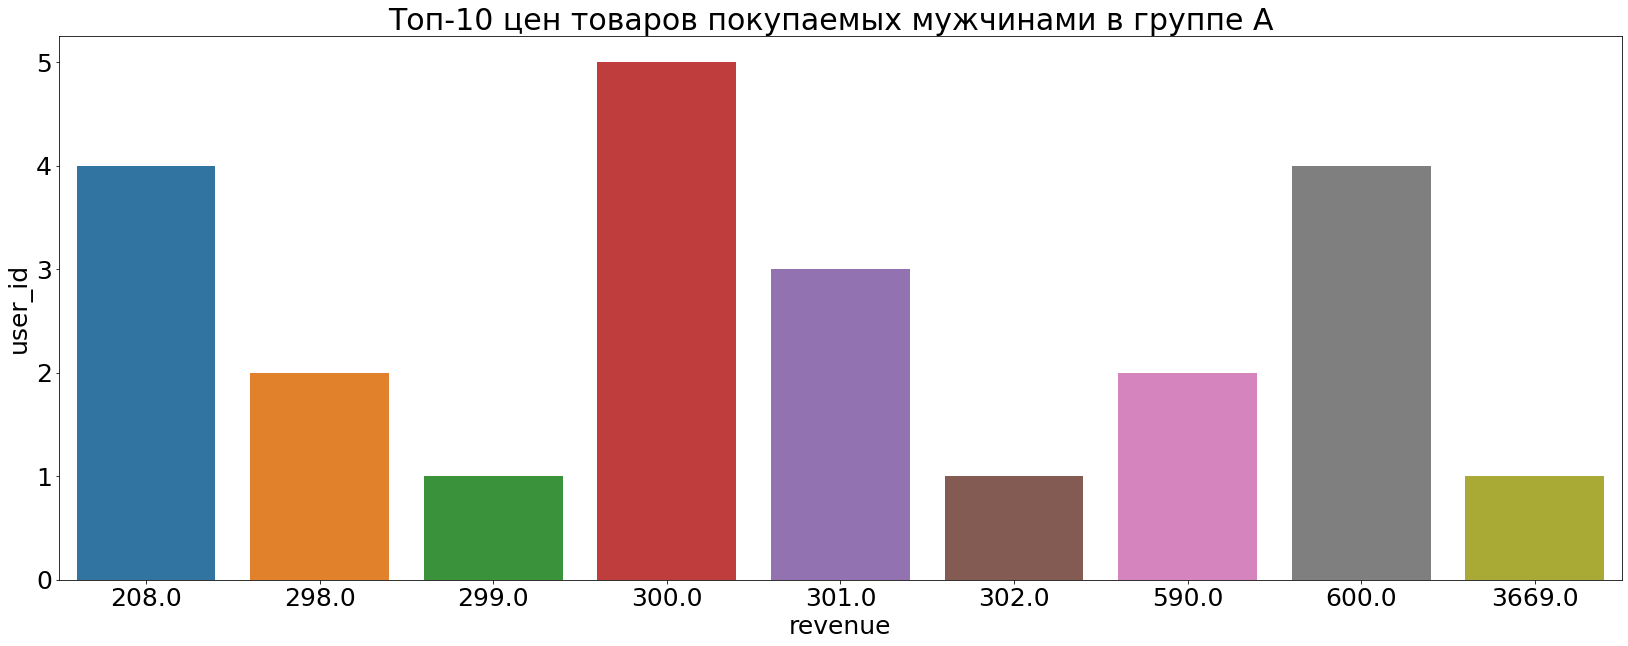

In [411]:
#бар плот топ-10 по количеству покупателей по разной цене в контрольной группе А для мужчин
plt.figure(figsize=(28,10))
ax = sns.barplot(x="revenue", y="user_id", data=male_A_top_revenue)
ax.set_title('Топ-10 цен товаров покупаемых мужчинами в группе A  ')

Расчет ARPPU для мужчин и жещин в группах А и В

In [337]:
#датасет для мужчин и женщин группы А
A_male_female=groups_with_ditails.merge(purchases, on='user_id').query('group=="A"')
A_male_female

,user_id,group,country,platform,sex,revenue
3,1673,A,Sweden,android,male,2899.0
10,5626,A,Sweden,android,male,208.0
18,4697,A,Sweden,ios,male,300.0
20,4412,A,Russia,android,female,1000.0
22,4770,A,Russia,android,male,998.0
...,...,...,...,...,...,...
370,2327,A,Sweden,ios,male,1048.0
372,3531,A,Sweden,android,male,300.0
374,1284,A,Russia,ios,male,1152.0
384,1681,A,Russia,ios,male,600.0


In [338]:
#датасет для мужчин и женщин группы В
B_male_female=groups_with_ditails.merge(purchases, on='user_id').query('group=="B"')
B_male_female

,user_id,group,country,platform,sex,revenue
0,4455,B,Russia,android,female,599.0
1,6473,B,Sweden,ios,female,3050.0
2,2814,B,Sweden,android,female,300.0
4,5505,B,Russia,android,male,299.0
5,7545,B,Sweden,android,male,299.0
...,...,...,...,...,...,...
386,239,B,Russia,ios,male,298.0
387,1259,B,Russia,ios,male,1398.0
389,6065,B,Sweden,ios,male,852.0
390,4850,B,Russia,android,female,1000.0


In [364]:
#среднее для мужчин и женщин группы А, совпадающее с ARPPU из за конверсии в повторную покупку равную 1.
mean_A_male_female=A_male_female.groupby('sex',as_index=False).agg({'revenue':'mean'}).sort_values('sex')
mean_A_male_female

,sex,revenue
0,female,856.945946
1,male,1021.731707


In [370]:
#среднее для мужчин и женщин группы В, совпадающее с ARPPU из за конверсии в повторную покупку равную 1.
mean_B_male_female=B_male_female.groupby('sex',as_index=False).agg({'revenue':'mean'}).sort_values('sex')
mean_B_male_female

,sex,revenue
0,female,1370.220779
1,male,1169.368750


In [374]:
# датасет со значениями ARPPU
mean_A_male_female['B_ARPPU']=mean_B_male_female.revenue
mean_A_male_female=mean_A_male_female.rename(columns={'revenue':'A_ARPPU'})
mean_A_male_female

,sex,A_ARPPU,B_ARPPU
0,female,856.945946,1370.220779
1,male,1021.731707,1169.368750


# Вывод

В итоге выкатывать новую модель оплаты на остальных пользователей нужно. Нововведение вынудило пользователей покупать товар по ценам 1909, 1910, 1911, хотя раньше они чаще всего покупали по ценам 300, 301, 600. С 95% вероятностью статистически значимо вырос ARPPU. При этом, с 95% вероятностью можно говорить о том, что остальные метрики статистически значимо не изменились.